In [1]:
import pandas as pd

DATASET_PATH = "./Truth_Seeker_Model_Dataset.csv"
df = pd.read_csv(DATASET_PATH)
df = df.loc[~((df['5_label_majority_answer'] == 'NO MAJORITY') | (df['3_label_majority_answer'] == 'NO MAJORITY'))]

print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df = df.sample(frac=1)

Number of training sentences: 111,593



In [2]:
sentences = 'Statement: ' + df['statement'] + '| Tweet: ' +df['tweet']

In [3]:
sentences[0]

'Statement: End of eviction moratorium means millions of Americans could lose their housing in the middle of a pandemic.| Tweet: @POTUS Biden Blunders - 6 Month Update\n\nInflation, Delta mismanagement, COVID for kids, Abandoning Americans in Afghanistan, Arming the Taliban, S. Border crisis, Breaking job growth, Abuse of power (Many Exec Orders, $3.5T through Reconciliation, Eviction Moratorium)...what did I miss?'

In [4]:
labels = df["BinaryNumTarget"].values

In [5]:
def generate_truthfulness_4way(row):
    if row['target'] == True:
        if row['5_label_majority_answer'] == 'Agree':
            return "True"
        elif row['5_label_majority_answer'] == 'Disagree':
            return "False"
        elif row['5_label_majority_answer'] == 'Mostly Agree':
            return "Mostly True"
        elif row['5_label_majority_answer'] == 'Mostly Disagree':
            return "Mostly False"
    else:
        if row['5_label_majority_answer'] == 'Agree':
            return "False"
        elif row['5_label_majority_answer'] == 'Disagree':
            return "True"
        elif row['5_label_majority_answer'] == 'Mostly Agree':
            return "Mostly False"
        elif row['5_label_majority_answer'] == 'Mostly Disagree':
            return "Mostly True"

def generate_truthfulness_2way(row):
    if row['target'] == True:
        if row['3_label_majority_answer'] == 'Agree':
            return "True"
        elif row['3_label_majority_answer'] == 'Disagree':
            return "False"
    else:
        if row['3_label_majority_answer'] == 'Agree':
            return "False"
        elif row['3_label_majority_answer'] == 'Disagree':
            return "True"
        

In [6]:
df2 = pd.DataFrame()
df2['4-way-label'] = df.apply(lambda x: generate_truthfulness_4way(x), axis=1)
df2['2-way-label'] = df.apply(lambda x: generate_truthfulness_2way(x), axis=1)

In [7]:
df2

,4-way-label,2-way-label
110397,False,False
100855,Mostly False,False
58691,True,True
4455,True,True
72511,Mostly True,True
...,...,...
64040,True,True
27862,True,True
115320,Mostly False,False
81209,Mostly False,False


In [8]:
df2['2-way-label'] = df2['2-way-label'].replace({'True': 0, 'False': 1})

/tmp/ipykernel_511802/487703377.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2['2-way-label'] = df2['2-way-label'].replace({'True': 0, 'False': 1})


In [9]:
df2

,4-way-label,2-way-label
110397,False,1
100855,Mostly False,1
58691,True,0
4455,True,0
72511,Mostly True,0
...,...,...
64040,True,0
27862,True,0
115320,Mostly False,1
81209,Mostly False,1


         4-way-label  2-way-label
110397         False            1
100855  Mostly False            1
58691           True            0
4455            True            0
72511    Mostly True            0
...              ...          ...
64040           True            0
27862           True            0
115320  Mostly False            1
81209   Mostly False            1
119907         False            1

[111593 rows x 2 columns]


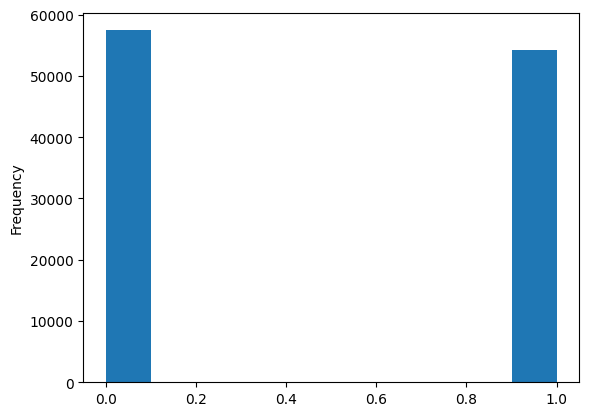

In [10]:
df2['2-way-label'].plot(kind='hist')
print(df2)

In [11]:
labels = df2['2-way-label'].values
labels

array([1, 1, 0, ..., 1, 1, 1])

In [12]:
import torch

print(torch.__version__)

2.5.1+cu124


In [13]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/home/nbuser/jcrowe/truth/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading BERT tokenizer...


In [14]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Statement: End of eviction moratorium means millions of Americans could lose their housing in the middle of a pandemic.| Tweet: @POTUS Biden Blunders - 6 Month Update

Inflation, Delta mismanagement, COVID for kids, Abandoning Americans in Afghanistan, Arming the Taliban, S. Border crisis, Breaking job growth, Abuse of power (Many Exec Orders, $3.5T through Reconciliation, Eviction Moratorium)...what did I miss?
Tokenized:  ['statement', ':', 'end', 'of', 'ev', '##iction', 'mora', '##torium', 'means', 'millions', 'of', 'americans', 'could', 'lose', 'their', 'housing', 'in', 'the', 'middle', 'of', 'a', 'pan', '##de', '##mic', '.', '|', 't', '##wee', '##t', ':', '@', 'pot', '##us', 'bid', '##en', 'blu', '##nder', '##s', '-', '6', 'month', 'update', 'inflation', ',', 'delta', 'mis', '##mana', '##gement', ',', 'co', '##vid', 'for', 'kids', ',', 'abandoning', 'americans', 'in', 'afghanistan', ',', 'arm', '##ing', 'the', 'taliban', ',', 's', '.', 'border', 'crisis', ',', 'breakin

In [15]:
max_len = 0
from tqdm import tqdm

# For every sentence...
for sent in tqdm(sentences):

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 111593/111593 [01:09<00:00, 1603.90it/s]

Max sentence length:  406


In [16]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
MAX_SENTENCE_LENGTH = 410

# For every sentence...
for sent in tqdm(sentences):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_SENTENCE_LENGTH,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])



  0%|                                                                                                                                                                                                                                               | 0/111593 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/nbuser/jcrowe/truth/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this cas

In [17]:
import torch
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

In [18]:

index = 10
# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[index])
print('Token IDs:', input_ids[index])
print ('Labels:', labels[index])

Original:  Statement: End of eviction moratorium means millions of Americans could lose their housing in the middle of a pandemic.| Tweet: BREAKING NEWS: Mitch McConnell accuses President Biden of pushing socialism by implementing the eviction moratorium that will stop millions of Americans from being thrown out on the street this month. RT if you think that Mitch is a heartless idiot!
Token IDs: tensor([  101,  4861,  1024,  2758,  6221,  8398,  1000,  4122,  2000,  2131,
         9436,  1997,  1996,  2976,  6263, 11897,  1012,  1000,  1064,  1056,
        28394,  2102,  1024,  1030,  5977,  4819, 22758,  2002,  2469,  4297,
        17572,  2019,  1000, 13760,  1000,  1999,  7912, 21877, 10483,  2072,
         2016,  1005,  1055,  2018,  1037,  2524,  2006,  2005,  8398,  2005,
         1018,  1012,  1019,  2086,  2085,  1048,  2863,  2080,  1998,  2053,
         4415,  2678,  1005,  1055,  1997,  3424,  7011,  5278,  2046,  8398,
        22054,  2035,  2058,  1996,  4274,  2023,  244

In [19]:
print(input_ids.shape)

torch.Size([111593, 410])


In [20]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

89,274 training samples
22,319 validation samples


In [21]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 2

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = RandomSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.,
        )

In [22]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [23]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [24]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/home/nbuser/jcrowe/truth/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [25]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# I'm running for 2 due to time.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [26]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [27]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    #torch.cuda.device(2) #did not work

    # Limit PyTorch to only 75% of GPU to not impact normal daily performance
    # torch.cuda.set_per_process_memory_fraction(0.75, 0)

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 4 GPU(s) available.
We will use the GPU: NVIDIA RTX 6000 Ada Generation


In [30]:
SAVE_DIR = './checkpoints/checkpoint_with_maxlength_410'

In [32]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()
    train_loss = 0
    total_fake_examples = 0
    total_true_examples = 0
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        #if step > 2000:
        #    break
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}. Training loss. {:} Num fake examples {:} Num true examples {:}'.format(step, len(train_dataloader), elapsed, train_loss,total_fake_examples, total_true_examples ))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(torch.int64).to(device)
        total_fake_examples += (b_labels == 1).sum().item()
        total_true_examples += (b_labels == 0).sum().item()
        #print (f"{b_labels.shape=}")
        b_labels_one_hot = torch.nn.functional.one_hot(b_labels, num_classes=2).float()
        #print (b_input_ids.shape, b_labels.shape, b_input_mask.shape, b_labels_one_hot.shape, b_labels_one_hot.dtype)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels_one_hot)
        loss = output.loss
        logits = output.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        train_loss= loss.item()
        total_train_loss += train_loss

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()
        #print (f"Training loss", loss.item())

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    
    for step, batch in enumerate(validation_dataloader):
        #if step > 2000:
        #    break
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(torch.int64).to(device)
        b_labels_one_hot = torch.nn.functional.one_hot(b_labels, num_classes=2).float()
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            
            output = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels_one_hot)
            loss = output.loss
            logits = output.logits


            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    #Save model checkpoint
    model.save_pretrained(SAVE_DIR)

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  44,637.    Elapsed: 0:00:02. Training loss. 0.004337724298238754 Num fake examples 42 Num true examples 38
  Batch    80  of  44,637.    Elapsed: 0:00:03. Training loss. 0.005030684173107147 Num fake examples 88 Num true examples 72
  Batch   120  of  44,637.    Elapsed: 0:00:05. Training loss. 0.00823903363198042 Num fake examples 127 Num true examples 113
  Batch   160  of  44,637.    Elapsed: 0:00:06. Training loss. 0.009292326867580414 Num fake examples 159 Num true examples 161
  Batch   200  of  44,637.    Elapsed: 0:00:08. Training loss. 0.009026182815432549 Num fake examples 202 Num true examples 198
  Batch   240  of  44,637.    Elapsed: 0:00:09. Training loss. 0.007299569435417652 Num fake examples 240 Num true examples 240
  Batch   280  of  44,637.    Elapsed: 0:00:11. Training loss. 0.01029890961945057 Num fake examples 285 Num true examples 275
  Batch   320  of  44,637.    Elapsed: 0:00:12. Training loss. 0.00

  Batch 2,600  of  44,637.    Elapsed: 0:01:36. Training loss. 0.005547362845391035 Num fake examples 2537 Num true examples 2663
  Batch 2,640  of  44,637.    Elapsed: 0:01:37. Training loss. 2.775083541870117 Num fake examples 2577 Num true examples 2703
  Batch 2,680  of  44,637.    Elapsed: 0:01:38. Training loss. 0.00566071318462491 Num fake examples 2615 Num true examples 2745
  Batch 2,720  of  44,637.    Elapsed: 0:01:40. Training loss. 2.6940231323242188 Num fake examples 2660 Num true examples 2780
  Batch 2,760  of  44,637.    Elapsed: 0:01:41. Training loss. 0.0048941937275230885 Num fake examples 2694 Num true examples 2826
  Batch 2,800  of  44,637.    Elapsed: 0:01:43. Training loss. 0.006894731894135475 Num fake examples 2734 Num true examples 2866
  Batch 2,840  of  44,637.    Elapsed: 0:01:44. Training loss. 0.005916972644627094 Num fake examples 2769 Num true examples 2911
  Batch 2,880  of  44,637.    Elapsed: 0:01:45. Training loss. 0.0031659086234867573 Num fake e

  Batch 5,160  of  44,637.    Elapsed: 0:03:04. Training loss. 0.005383627023547888 Num fake examples 5072 Num true examples 5248
  Batch 5,200  of  44,637.    Elapsed: 0:03:05. Training loss. 2.4754676818847656 Num fake examples 5110 Num true examples 5290
  Batch 5,240  of  44,637.    Elapsed: 0:03:07. Training loss. 0.007156681269407272 Num fake examples 5154 Num true examples 5326
  Batch 5,280  of  44,637.    Elapsed: 0:03:08. Training loss. 0.005650166887789965 Num fake examples 5190 Num true examples 5370
  Batch 5,320  of  44,637.    Elapsed: 0:03:09. Training loss. 0.0043754735961556435 Num fake examples 5225 Num true examples 5415
  Batch 5,360  of  44,637.    Elapsed: 0:03:11. Training loss. 0.006977427750825882 Num fake examples 5264 Num true examples 5456
  Batch 5,400  of  44,637.    Elapsed: 0:03:12. Training loss. 0.004458259791135788 Num fake examples 5308 Num true examples 5492
  Batch 5,440  of  44,637.    Elapsed: 0:03:13. Training loss. 0.002977767726406455 Num fak

  Batch 7,680  of  44,637.    Elapsed: 0:04:31. Training loss. 0.0028185760602355003 Num fake examples 7508 Num true examples 7852
  Batch 7,720  of  44,637.    Elapsed: 0:04:32. Training loss. 0.0030230102129280567 Num fake examples 7555 Num true examples 7885
  Batch 7,760  of  44,637.    Elapsed: 0:04:33. Training loss. 0.004068086389452219 Num fake examples 7592 Num true examples 7928
  Batch 7,800  of  44,637.    Elapsed: 0:04:35. Training loss. 0.004043779335916042 Num fake examples 7626 Num true examples 7974
  Batch 7,840  of  44,637.    Elapsed: 0:04:36. Training loss. 0.004418394528329372 Num fake examples 7663 Num true examples 8017
  Batch 7,880  of  44,637.    Elapsed: 0:04:38. Training loss. 0.0036345920525491238 Num fake examples 7704 Num true examples 8056
  Batch 7,920  of  44,637.    Elapsed: 0:04:39. Training loss. 0.0036560306325554848 Num fake examples 7740 Num true examples 8100
  Batch 7,960  of  44,637.    Elapsed: 0:04:40. Training loss. 0.0036801202222704887 N

  Batch 10,200  of  44,637.    Elapsed: 0:06:03. Training loss. 0.004991017747670412 Num fake examples 9967 Num true examples 10433
  Batch 10,240  of  44,637.    Elapsed: 0:06:05. Training loss. 0.005397241096943617 Num fake examples 10001 Num true examples 10479
  Batch 10,280  of  44,637.    Elapsed: 0:06:06. Training loss. 2.678415536880493 Num fake examples 10045 Num true examples 10515
  Batch 10,320  of  44,637.    Elapsed: 0:06:08. Training loss. 0.003925509750843048 Num fake examples 10078 Num true examples 10562
  Batch 10,360  of  44,637.    Elapsed: 0:06:09. Training loss. 0.0029263191390782595 Num fake examples 10114 Num true examples 10606
  Batch 10,400  of  44,637.    Elapsed: 0:06:10. Training loss. 0.0028263796120882034 Num fake examples 10150 Num true examples 10650
  Batch 10,440  of  44,637.    Elapsed: 0:06:12. Training loss. 2.8986425399780273 Num fake examples 10189 Num true examples 10691
  Batch 10,480  of  44,637.    Elapsed: 0:06:13. Training loss. 0.0036711

  Batch 12,680  of  44,637.    Elapsed: 0:07:28. Training loss. 0.005264408886432648 Num fake examples 12337 Num true examples 13023
  Batch 12,720  of  44,637.    Elapsed: 0:07:29. Training loss. 0.004317945800721645 Num fake examples 12384 Num true examples 13056
  Batch 12,760  of  44,637.    Elapsed: 0:07:31. Training loss. 0.002964756917208433 Num fake examples 12425 Num true examples 13095
  Batch 12,800  of  44,637.    Elapsed: 0:07:32. Training loss. 0.0032511891331523657 Num fake examples 12464 Num true examples 13136
  Batch 12,840  of  44,637.    Elapsed: 0:07:33. Training loss. 0.003173163626343012 Num fake examples 12503 Num true examples 13177
  Batch 12,880  of  44,637.    Elapsed: 0:07:35. Training loss. 0.0033897575922310352 Num fake examples 12535 Num true examples 13225
  Batch 12,920  of  44,637.    Elapsed: 0:07:36. Training loss. 0.0025975164026021957 Num fake examples 12568 Num true examples 13272
  Batch 12,960  of  44,637.    Elapsed: 0:07:37. Training loss. 0.

  Batch 15,160  of  44,637.    Elapsed: 0:08:52. Training loss. 0.003645986318588257 Num fake examples 14743 Num true examples 15577
  Batch 15,200  of  44,637.    Elapsed: 0:08:54. Training loss. 0.002570203971117735 Num fake examples 14776 Num true examples 15624
  Batch 15,240  of  44,637.    Elapsed: 0:08:55. Training loss. 0.002748622326180339 Num fake examples 14818 Num true examples 15662
  Batch 15,280  of  44,637.    Elapsed: 0:08:56. Training loss. 0.00350895500741899 Num fake examples 14856 Num true examples 15704
  Batch 15,320  of  44,637.    Elapsed: 0:08:58. Training loss. 0.0039450861513614655 Num fake examples 14899 Num true examples 15741
  Batch 15,360  of  44,637.    Elapsed: 0:08:59. Training loss. 0.003703142050653696 Num fake examples 14933 Num true examples 15787
  Batch 15,400  of  44,637.    Elapsed: 0:09:00. Training loss. 0.0038548624143004417 Num fake examples 14968 Num true examples 15832
  Batch 15,440  of  44,637.    Elapsed: 0:09:02. Training loss. 0.00

  Batch 17,640  of  44,637.    Elapsed: 0:10:17. Training loss. 0.00666718790307641 Num fake examples 17184 Num true examples 18096
  Batch 17,680  of  44,637.    Elapsed: 0:10:18. Training loss. 0.00535806268453598 Num fake examples 17220 Num true examples 18140
  Batch 17,720  of  44,637.    Elapsed: 0:10:19. Training loss. 0.004941048100590706 Num fake examples 17262 Num true examples 18178
  Batch 17,760  of  44,637.    Elapsed: 0:10:21. Training loss. 2.6580073833465576 Num fake examples 17298 Num true examples 18222
  Batch 17,800  of  44,637.    Elapsed: 0:10:22. Training loss. 0.005949316080659628 Num fake examples 17329 Num true examples 18271
  Batch 17,840  of  44,637.    Elapsed: 0:10:23. Training loss. 0.006494381930679083 Num fake examples 17369 Num true examples 18311
  Batch 17,880  of  44,637.    Elapsed: 0:10:25. Training loss. 0.004841960966587067 Num fake examples 17405 Num true examples 18355
  Batch 17,920  of  44,637.    Elapsed: 0:10:26. Training loss. 0.0045968

  Batch 20,120  of  44,637.    Elapsed: 0:11:41. Training loss. 0.003594201523810625 Num fake examples 19576 Num true examples 20664
  Batch 20,160  of  44,637.    Elapsed: 0:11:42. Training loss. 2.805429458618164 Num fake examples 19620 Num true examples 20700
  Batch 20,200  of  44,637.    Elapsed: 0:11:43. Training loss. 0.0028133837040513754 Num fake examples 19648 Num true examples 20752
  Batch 20,240  of  44,637.    Elapsed: 0:11:45. Training loss. 2.9478862285614014 Num fake examples 19688 Num true examples 20792
  Batch 20,280  of  44,637.    Elapsed: 0:11:46. Training loss. 0.004856398329138756 Num fake examples 19731 Num true examples 20829
  Batch 20,320  of  44,637.    Elapsed: 0:11:48. Training loss. 0.004170049447566271 Num fake examples 19774 Num true examples 20866
  Batch 20,360  of  44,637.    Elapsed: 0:11:49. Training loss. 0.004195463843643665 Num fake examples 19816 Num true examples 20904
  Batch 20,400  of  44,637.    Elapsed: 0:11:50. Training loss. 0.0037415

  Batch 22,600  of  44,637.    Elapsed: 0:13:06. Training loss. 0.0041538989171385765 Num fake examples 21961 Num true examples 23239
  Batch 22,640  of  44,637.    Elapsed: 0:13:07. Training loss. 0.004881605971604586 Num fake examples 21998 Num true examples 23282
  Batch 22,680  of  44,637.    Elapsed: 0:13:08. Training loss. 0.00393727608025074 Num fake examples 22038 Num true examples 23322
  Batch 22,720  of  44,637.    Elapsed: 0:13:10. Training loss. 0.006764019839465618 Num fake examples 22086 Num true examples 23354
  Batch 22,760  of  44,637.    Elapsed: 0:13:11. Training loss. 0.005902543663978577 Num fake examples 22120 Num true examples 23400
  Batch 22,800  of  44,637.    Elapsed: 0:13:12. Training loss. 0.005868511740118265 Num fake examples 22163 Num true examples 23437
  Batch 22,840  of  44,637.    Elapsed: 0:13:14. Training loss. 0.003869712818413973 Num fake examples 22203 Num true examples 23477
  Batch 22,880  of  44,637.    Elapsed: 0:13:15. Training loss. 0.005

  Batch 25,080  of  44,637.    Elapsed: 0:14:30. Training loss. 0.004131588153541088 Num fake examples 24371 Num true examples 25789
  Batch 25,120  of  44,637.    Elapsed: 0:14:31. Training loss. 0.0035858270712196827 Num fake examples 24413 Num true examples 25827
  Batch 25,160  of  44,637.    Elapsed: 0:14:32. Training loss. 0.003207125701010227 Num fake examples 24453 Num true examples 25867
  Batch 25,200  of  44,637.    Elapsed: 0:14:34. Training loss. 0.003502995241433382 Num fake examples 24492 Num true examples 25908
  Batch 25,240  of  44,637.    Elapsed: 0:14:35. Training loss. 0.003737292718142271 Num fake examples 24531 Num true examples 25949
  Batch 25,280  of  44,637.    Elapsed: 0:14:37. Training loss. 0.003203268861398101 Num fake examples 24578 Num true examples 25982
  Batch 25,320  of  44,637.    Elapsed: 0:14:38. Training loss. 2.6874194145202637 Num fake examples 24619 Num true examples 26021
  Batch 25,360  of  44,637.    Elapsed: 0:14:39. Training loss. 0.0038

  Batch 27,560  of  44,637.    Elapsed: 0:15:54. Training loss. 0.00393792986869812 Num fake examples 26848 Num true examples 28272
  Batch 27,600  of  44,637.    Elapsed: 0:15:55. Training loss. 0.0036313256714493036 Num fake examples 26889 Num true examples 28311
  Batch 27,640  of  44,637.    Elapsed: 0:15:57. Training loss. 0.004383870866149664 Num fake examples 26926 Num true examples 28354
  Batch 27,680  of  44,637.    Elapsed: 0:15:58. Training loss. 0.0047114696353673935 Num fake examples 26960 Num true examples 28400
  Batch 27,720  of  44,637.    Elapsed: 0:15:59. Training loss. 0.003646712051704526 Num fake examples 26991 Num true examples 28449
  Batch 27,760  of  44,637.    Elapsed: 0:16:01. Training loss. 0.00410042516887188 Num fake examples 27029 Num true examples 28491
  Batch 27,800  of  44,637.    Elapsed: 0:16:02. Training loss. 0.004108780063688755 Num fake examples 27065 Num true examples 28535
  Batch 27,840  of  44,637.    Elapsed: 0:16:04. Training loss. 0.003

  Batch 30,040  of  44,637.    Elapsed: 0:17:19. Training loss. 0.0030222320929169655 Num fake examples 29246 Num true examples 30834
  Batch 30,080  of  44,637.    Elapsed: 0:17:21. Training loss. 0.003880023490637541 Num fake examples 29284 Num true examples 30876
  Batch 30,120  of  44,637.    Elapsed: 0:17:22. Training loss. 0.0032955228816717863 Num fake examples 29328 Num true examples 30912
  Batch 30,160  of  44,637.    Elapsed: 0:17:24. Training loss. 0.00290493480861187 Num fake examples 29365 Num true examples 30955
  Batch 30,200  of  44,637.    Elapsed: 0:17:25. Training loss. 0.0024547011125832796 Num fake examples 29400 Num true examples 31000
  Batch 30,240  of  44,637.    Elapsed: 0:17:26. Training loss. 0.002777255140244961 Num fake examples 29433 Num true examples 31047
  Batch 30,280  of  44,637.    Elapsed: 0:17:28. Training loss. 0.0029691560193896294 Num fake examples 29476 Num true examples 31084
  Batch 30,320  of  44,637.    Elapsed: 0:17:29. Training loss. 0.

  Batch 32,520  of  44,637.    Elapsed: 0:18:44. Training loss. 0.0037184078246355057 Num fake examples 31661 Num true examples 33379
  Batch 32,560  of  44,637.    Elapsed: 0:18:46. Training loss. 0.0034297904931008816 Num fake examples 31703 Num true examples 33417
  Batch 32,600  of  44,637.    Elapsed: 0:18:47. Training loss. 2.840902090072632 Num fake examples 31744 Num true examples 33456
  Batch 32,640  of  44,637.    Elapsed: 0:18:48. Training loss. 0.0034844980109483004 Num fake examples 31781 Num true examples 33499
  Batch 32,680  of  44,637.    Elapsed: 0:18:50. Training loss. 0.003379338886588812 Num fake examples 31815 Num true examples 33545
  Batch 32,720  of  44,637.    Elapsed: 0:18:51. Training loss. 0.0033930581994354725 Num fake examples 31847 Num true examples 33593
  Batch 32,760  of  44,637.    Elapsed: 0:18:52. Training loss. 0.004047050140798092 Num fake examples 31882 Num true examples 33638
  Batch 32,800  of  44,637.    Elapsed: 0:18:54. Training loss. 0.00

  Batch 35,000  of  44,637.    Elapsed: 0:20:09. Training loss. 0.003488492453470826 Num fake examples 33998 Num true examples 36002
  Batch 35,040  of  44,637.    Elapsed: 0:20:10. Training loss. 0.0033848010934889317 Num fake examples 34039 Num true examples 36041
  Batch 35,080  of  44,637.    Elapsed: 0:20:12. Training loss. 0.0040693096816539764 Num fake examples 34075 Num true examples 36085
  Batch 35,120  of  44,637.    Elapsed: 0:20:13. Training loss. 0.003434994723647833 Num fake examples 34119 Num true examples 36121
  Batch 35,160  of  44,637.    Elapsed: 0:20:14. Training loss. 0.0034820889122784138 Num fake examples 34161 Num true examples 36159
  Batch 35,200  of  44,637.    Elapsed: 0:20:16. Training loss. 0.0036317072808742523 Num fake examples 34198 Num true examples 36202
  Batch 35,240  of  44,637.    Elapsed: 0:20:17. Training loss. 0.0033148033544421196 Num fake examples 34234 Num true examples 36246
  Batch 35,280  of  44,637.    Elapsed: 0:20:18. Training loss. 

  Batch 37,480  of  44,637.    Elapsed: 0:21:33. Training loss. 0.0028955063316971064 Num fake examples 36380 Num true examples 38580
  Batch 37,520  of  44,637.    Elapsed: 0:21:35. Training loss. 0.0036180256865918636 Num fake examples 36423 Num true examples 38617
  Batch 37,560  of  44,637.    Elapsed: 0:21:36. Training loss. 0.0018252701265737414 Num fake examples 36463 Num true examples 38657
  Batch 37,600  of  44,637.    Elapsed: 0:21:37. Training loss. 0.0029108698945492506 Num fake examples 36500 Num true examples 38700
  Batch 37,640  of  44,637.    Elapsed: 0:21:39. Training loss. 0.0028363827150315046 Num fake examples 36544 Num true examples 38736
  Batch 37,680  of  44,637.    Elapsed: 0:21:40. Training loss. 0.003225734457373619 Num fake examples 36581 Num true examples 38779
  Batch 37,720  of  44,637.    Elapsed: 0:21:41. Training loss. 0.002677041105926037 Num fake examples 36618 Num true examples 38822
  Batch 37,760  of  44,637.    Elapsed: 0:21:43. Training loss. 

  Batch 39,960  of  44,637.    Elapsed: 0:22:58. Training loss. 0.003981154412031174 Num fake examples 38820 Num true examples 41100
  Batch 40,000  of  44,637.    Elapsed: 0:22:59. Training loss. 0.003903804812580347 Num fake examples 38857 Num true examples 41143
  Batch 40,040  of  44,637.    Elapsed: 0:23:00. Training loss. 0.003031305270269513 Num fake examples 38895 Num true examples 41185
  Batch 40,080  of  44,637.    Elapsed: 0:23:02. Training loss. 0.0035999740939587355 Num fake examples 38938 Num true examples 41222
  Batch 40,120  of  44,637.    Elapsed: 0:23:03. Training loss. 0.003043015953153372 Num fake examples 38972 Num true examples 41268
  Batch 40,160  of  44,637.    Elapsed: 0:23:04. Training loss. 0.0027947358321398497 Num fake examples 39014 Num true examples 41306
  Batch 40,200  of  44,637.    Elapsed: 0:23:06. Training loss. 0.003532904665917158 Num fake examples 39050 Num true examples 41350
  Batch 40,240  of  44,637.    Elapsed: 0:23:07. Training loss. 0.0

  Batch 42,440  of  44,637.    Elapsed: 0:24:22. Training loss. 0.004611083772033453 Num fake examples 41257 Num true examples 43623
  Batch 42,480  of  44,637.    Elapsed: 0:24:23. Training loss. 0.0038838335312902927 Num fake examples 41301 Num true examples 43659
  Batch 42,520  of  44,637.    Elapsed: 0:24:25. Training loss. 0.003912129905074835 Num fake examples 41341 Num true examples 43699
  Batch 42,560  of  44,637.    Elapsed: 0:24:26. Training loss. 0.004142396152019501 Num fake examples 41378 Num true examples 43742
  Batch 42,600  of  44,637.    Elapsed: 0:24:27. Training loss. 0.003998486790806055 Num fake examples 41417 Num true examples 43783
  Batch 42,640  of  44,637.    Elapsed: 0:24:29. Training loss. 0.004154810216277838 Num fake examples 41451 Num true examples 43829
  Batch 42,680  of  44,637.    Elapsed: 0:24:30. Training loss. 0.0037347343750298023 Num fake examples 41491 Num true examples 43869
  Batch 42,720  of  44,637.    Elapsed: 0:24:32. Training loss. 0.0

  Batch   280  of  44,637.    Elapsed: 0:00:09. Training loss. 0.003194661345332861 Num fake examples 266 Num true examples 294
  Batch   320  of  44,637.    Elapsed: 0:00:11. Training loss. 0.005099664442241192 Num fake examples 306 Num true examples 334
  Batch   360  of  44,637.    Elapsed: 0:00:12. Training loss. 0.004661020822823048 Num fake examples 347 Num true examples 373
  Batch   400  of  44,637.    Elapsed: 0:00:13. Training loss. 0.0032441269140690565 Num fake examples 378 Num true examples 422
  Batch   440  of  44,637.    Elapsed: 0:00:15. Training loss. 2.8121094703674316 Num fake examples 414 Num true examples 466
  Batch   480  of  44,637.    Elapsed: 0:00:16. Training loss. 2.758197069168091 Num fake examples 454 Num true examples 506
  Batch   520  of  44,637.    Elapsed: 0:00:17. Training loss. 0.004781815689057112 Num fake examples 495 Num true examples 545
  Batch   560  of  44,637.    Elapsed: 0:00:19. Training loss. 0.0050916182808578014 Num fake examples 535 N

  Batch 2,840  of  44,637.    Elapsed: 0:01:36. Training loss. 0.00334569183178246 Num fake examples 2723 Num true examples 2957
  Batch 2,880  of  44,637.    Elapsed: 0:01:38. Training loss. 2.795090675354004 Num fake examples 2762 Num true examples 2998
  Batch 2,920  of  44,637.    Elapsed: 0:01:39. Training loss. 0.004975479561835527 Num fake examples 2808 Num true examples 3032
  Batch 2,960  of  44,637.    Elapsed: 0:01:41. Training loss. 0.003844038350507617 Num fake examples 2842 Num true examples 3078
  Batch 3,000  of  44,637.    Elapsed: 0:01:42. Training loss. 0.004250291734933853 Num fake examples 2877 Num true examples 3123
  Batch 3,040  of  44,637.    Elapsed: 0:01:44. Training loss. 0.003931797109544277 Num fake examples 2913 Num true examples 3167
  Batch 3,080  of  44,637.    Elapsed: 0:01:46. Training loss. 0.004272051155567169 Num fake examples 2954 Num true examples 3206
  Batch 3,120  of  44,637.    Elapsed: 0:01:47. Training loss. 0.0042154304683208466 Num fake 

  Batch 5,360  of  44,637.    Elapsed: 0:03:07. Training loss. 0.004083877429366112 Num fake examples 5105 Num true examples 5615
  Batch 5,400  of  44,637.    Elapsed: 0:03:08. Training loss. 0.0035773231647908688 Num fake examples 5145 Num true examples 5655
  Batch 5,440  of  44,637.    Elapsed: 0:03:09. Training loss. 0.003989210352301598 Num fake examples 5186 Num true examples 5694
  Batch 5,480  of  44,637.    Elapsed: 0:03:11. Training loss. 0.004380741622298956 Num fake examples 5228 Num true examples 5732
  Batch 5,520  of  44,637.    Elapsed: 0:03:12. Training loss. 0.003974552731961012 Num fake examples 5272 Num true examples 5768
  Batch 5,560  of  44,637.    Elapsed: 0:03:13. Training loss. 0.003258579410612583 Num fake examples 5311 Num true examples 5809
  Batch 5,600  of  44,637.    Elapsed: 0:03:15. Training loss. 0.003856887575238943 Num fake examples 5352 Num true examples 5848
  Batch 5,640  of  44,637.    Elapsed: 0:03:16. Training loss. 0.004083923064172268 Num f

  Batch 7,880  of  44,637.    Elapsed: 0:04:33. Training loss. 0.004208666738122702 Num fake examples 7537 Num true examples 8223
  Batch 7,920  of  44,637.    Elapsed: 0:04:35. Training loss. 0.003236562479287386 Num fake examples 7567 Num true examples 8273
  Batch 7,960  of  44,637.    Elapsed: 0:04:36. Training loss. 0.003239500103518367 Num fake examples 7605 Num true examples 8315
  Batch 8,000  of  44,637.    Elapsed: 0:04:37. Training loss. 0.004199416376650333 Num fake examples 7648 Num true examples 8352
  Batch 8,040  of  44,637.    Elapsed: 0:04:39. Training loss. 0.0034196830820292234 Num fake examples 7677 Num true examples 8403
  Batch 8,080  of  44,637.    Elapsed: 0:04:40. Training loss. 0.00335519528016448 Num fake examples 7722 Num true examples 8438
  Batch 8,120  of  44,637.    Elapsed: 0:04:42. Training loss. 0.00406300276517868 Num fake examples 7762 Num true examples 8478
  Batch 8,160  of  44,637.    Elapsed: 0:04:43. Training loss. 0.003345048986375332 Num fak

  Batch 10,400  of  44,637.    Elapsed: 0:05:59. Training loss. 0.003256595227867365 Num fake examples 9983 Num true examples 10817
  Batch 10,440  of  44,637.    Elapsed: 0:06:01. Training loss. 0.0035906180273741484 Num fake examples 10026 Num true examples 10854
  Batch 10,480  of  44,637.    Elapsed: 0:06:02. Training loss. 0.0031511960551142693 Num fake examples 10066 Num true examples 10894
  Batch 10,520  of  44,637.    Elapsed: 0:06:03. Training loss. 2.9343814849853516 Num fake examples 10098 Num true examples 10942
  Batch 10,560  of  44,637.    Elapsed: 0:06:05. Training loss. 0.003142360132187605 Num fake examples 10132 Num true examples 10988
  Batch 10,600  of  44,637.    Elapsed: 0:06:06. Training loss. 0.002978648291900754 Num fake examples 10174 Num true examples 11026
  Batch 10,640  of  44,637.    Elapsed: 0:06:08. Training loss. 0.002387796062976122 Num fake examples 10217 Num true examples 11063
  Batch 10,680  of  44,637.    Elapsed: 0:06:09. Training loss. 0.0026

  Batch 12,880  of  44,637.    Elapsed: 0:07:24. Training loss. 0.0037236043717712164 Num fake examples 12359 Num true examples 13401
  Batch 12,920  of  44,637.    Elapsed: 0:07:26. Training loss. 2.819333076477051 Num fake examples 12397 Num true examples 13443
  Batch 12,960  of  44,637.    Elapsed: 0:07:27. Training loss. 2.8255908489227295 Num fake examples 12430 Num true examples 13490
  Batch 13,000  of  44,637.    Elapsed: 0:07:28. Training loss. 0.0038886258844286203 Num fake examples 12463 Num true examples 13537
  Batch 13,040  of  44,637.    Elapsed: 0:07:30. Training loss. 0.004371829330921173 Num fake examples 12504 Num true examples 13576
  Batch 13,080  of  44,637.    Elapsed: 0:07:31. Training loss. 0.003238759469240904 Num fake examples 12546 Num true examples 13614
  Batch 13,120  of  44,637.    Elapsed: 0:07:32. Training loss. 0.004018479026854038 Num fake examples 12588 Num true examples 13652
  Batch 13,160  of  44,637.    Elapsed: 0:07:34. Training loss. 0.003532

  Batch 15,360  of  44,637.    Elapsed: 0:08:49. Training loss. 0.0032967247534543276 Num fake examples 14757 Num true examples 15963
  Batch 15,400  of  44,637.    Elapsed: 0:08:50. Training loss. 0.003687222022563219 Num fake examples 14792 Num true examples 16008
  Batch 15,440  of  44,637.    Elapsed: 0:08:52. Training loss. 0.0033118375577032566 Num fake examples 14835 Num true examples 16045
  Batch 15,480  of  44,637.    Elapsed: 0:08:53. Training loss. 2.784710645675659 Num fake examples 14876 Num true examples 16084
  Batch 15,520  of  44,637.    Elapsed: 0:08:54. Training loss. 0.0047057196497917175 Num fake examples 14905 Num true examples 16135
  Batch 15,560  of  44,637.    Elapsed: 0:08:56. Training loss. 0.0028054227586835623 Num fake examples 14938 Num true examples 16182
  Batch 15,600  of  44,637.    Elapsed: 0:08:57. Training loss. 0.00322955590672791 Num fake examples 14971 Num true examples 16229
  Batch 15,640  of  44,637.    Elapsed: 0:08:58. Training loss. 0.003

  Batch 17,840  of  44,637.    Elapsed: 0:10:14. Training loss. 0.0029057541396468878 Num fake examples 17194 Num true examples 18486
  Batch 17,880  of  44,637.    Elapsed: 0:10:16. Training loss. 0.0032019484788179398 Num fake examples 17236 Num true examples 18524
  Batch 17,920  of  44,637.    Elapsed: 0:10:17. Training loss. 0.0033928793855011463 Num fake examples 17271 Num true examples 18569
  Batch 17,960  of  44,637.    Elapsed: 0:10:18. Training loss. 0.0030052755028009415 Num fake examples 17313 Num true examples 18607
  Batch 18,000  of  44,637.    Elapsed: 0:10:20. Training loss. 0.0031182568054646254 Num fake examples 17347 Num true examples 18653
  Batch 18,040  of  44,637.    Elapsed: 0:10:21. Training loss. 0.0032156435772776604 Num fake examples 17385 Num true examples 18695
  Batch 18,080  of  44,637.    Elapsed: 0:10:23. Training loss. 0.0034844032488763332 Num fake examples 17423 Num true examples 18737
  Batch 18,120  of  44,637.    Elapsed: 0:10:24. Training loss

  Batch 20,320  of  44,637.    Elapsed: 0:11:39. Training loss. 0.003369659185409546 Num fake examples 19595 Num true examples 21045
  Batch 20,360  of  44,637.    Elapsed: 0:11:41. Training loss. 0.0031556319445371628 Num fake examples 19633 Num true examples 21087
  Batch 20,400  of  44,637.    Elapsed: 0:11:42. Training loss. 0.0036646185908466578 Num fake examples 19678 Num true examples 21122
  Batch 20,440  of  44,637.    Elapsed: 0:11:43. Training loss. 0.00365788908675313 Num fake examples 19715 Num true examples 21165
  Batch 20,480  of  44,637.    Elapsed: 0:11:45. Training loss. 0.0036042919382452965 Num fake examples 19759 Num true examples 21201
  Batch 20,520  of  44,637.    Elapsed: 0:11:46. Training loss. 0.00303816725499928 Num fake examples 19794 Num true examples 21246
  Batch 20,560  of  44,637.    Elapsed: 0:11:48. Training loss. 0.003919185139238834 Num fake examples 19832 Num true examples 21288
  Batch 20,600  of  44,637.    Elapsed: 0:11:49. Training loss. 0.00

  Batch 22,800  of  44,637.    Elapsed: 0:13:04. Training loss. 0.003170476760715246 Num fake examples 21958 Num true examples 23642
  Batch 22,840  of  44,637.    Elapsed: 0:13:05. Training loss. 0.0034276177175343037 Num fake examples 22002 Num true examples 23678
  Batch 22,880  of  44,637.    Elapsed: 0:13:07. Training loss. 0.0036233551800251007 Num fake examples 22054 Num true examples 23706
  Batch 22,920  of  44,637.    Elapsed: 0:13:08. Training loss. 0.003666588570922613 Num fake examples 22093 Num true examples 23747
  Batch 22,960  of  44,637.    Elapsed: 0:13:09. Training loss. 0.0030130897648632526 Num fake examples 22136 Num true examples 23784
  Batch 23,000  of  44,637.    Elapsed: 0:13:11. Training loss. 0.004235174972563982 Num fake examples 22175 Num true examples 23825
  Batch 23,040  of  44,637.    Elapsed: 0:13:12. Training loss. 0.0032149350736290216 Num fake examples 22216 Num true examples 23864
  Batch 23,080  of  44,637.    Elapsed: 0:13:14. Training loss. 0

  Batch 25,280  of  44,637.    Elapsed: 0:14:28. Training loss. 0.0031998001504689455 Num fake examples 24346 Num true examples 26214
  Batch 25,320  of  44,637.    Elapsed: 0:14:30. Training loss. 0.0033661765046417713 Num fake examples 24383 Num true examples 26257
  Batch 25,360  of  44,637.    Elapsed: 0:14:31. Training loss. 0.00436544930562377 Num fake examples 24417 Num true examples 26303
  Batch 25,400  of  44,637.    Elapsed: 0:14:33. Training loss. 0.0034050371032208204 Num fake examples 24456 Num true examples 26344
  Batch 25,440  of  44,637.    Elapsed: 0:14:34. Training loss. 0.0037542995996773243 Num fake examples 24503 Num true examples 26377
  Batch 25,480  of  44,637.    Elapsed: 0:14:35. Training loss. 0.0032737883739173412 Num fake examples 24538 Num true examples 26422
  Batch 25,520  of  44,637.    Elapsed: 0:14:37. Training loss. 0.00436962116509676 Num fake examples 24582 Num true examples 26458
  Batch 25,560  of  44,637.    Elapsed: 0:14:38. Training loss. 0.

  Batch 27,760  of  44,637.    Elapsed: 0:15:53. Training loss. 0.002967757172882557 Num fake examples 26761 Num true examples 28759
  Batch 27,800  of  44,637.    Elapsed: 0:15:54. Training loss. 0.0033457756508141756 Num fake examples 26807 Num true examples 28793
  Batch 27,840  of  44,637.    Elapsed: 0:15:56. Training loss. 0.0034067381639033556 Num fake examples 26847 Num true examples 28833
  Batch 27,880  of  44,637.    Elapsed: 0:15:57. Training loss. 0.004680235404521227 Num fake examples 26880 Num true examples 28880
  Batch 27,920  of  44,637.    Elapsed: 0:15:58. Training loss. 0.004026732873171568 Num fake examples 26914 Num true examples 28926
  Batch 27,960  of  44,637.    Elapsed: 0:16:00. Training loss. 0.004091443493962288 Num fake examples 26958 Num true examples 28962
  Batch 28,000  of  44,637.    Elapsed: 0:16:01. Training loss. 0.0031488374806940556 Num fake examples 26997 Num true examples 29003
  Batch 28,040  of  44,637.    Elapsed: 0:16:02. Training loss. 0.

  Batch 30,240  of  44,637.    Elapsed: 0:17:17. Training loss. 0.004342446103692055 Num fake examples 29136 Num true examples 31344
  Batch 30,280  of  44,637.    Elapsed: 0:17:18. Training loss. 0.004009315278381109 Num fake examples 29167 Num true examples 31393
  Batch 30,320  of  44,637.    Elapsed: 0:17:20. Training loss. 0.004092744551599026 Num fake examples 29212 Num true examples 31428
  Batch 30,360  of  44,637.    Elapsed: 0:17:21. Training loss. 0.004458365496248007 Num fake examples 29259 Num true examples 31461
  Batch 30,400  of  44,637.    Elapsed: 0:17:23. Training loss. 0.003906805533915758 Num fake examples 29306 Num true examples 31494
  Batch 30,440  of  44,637.    Elapsed: 0:17:24. Training loss. 0.003909691236913204 Num fake examples 29340 Num true examples 31540
  Batch 30,480  of  44,637.    Elapsed: 0:17:25. Training loss. 0.004401272162795067 Num fake examples 29382 Num true examples 31578
  Batch 30,520  of  44,637.    Elapsed: 0:17:27. Training loss. 0.003

  Batch 32,720  of  44,637.    Elapsed: 0:18:41. Training loss. 0.0034747174941003323 Num fake examples 31574 Num true examples 33866
  Batch 32,760  of  44,637.    Elapsed: 0:18:43. Training loss. 0.003583331126719713 Num fake examples 31615 Num true examples 33905
  Batch 32,800  of  44,637.    Elapsed: 0:18:44. Training loss. 0.0035250592045485973 Num fake examples 31658 Num true examples 33942
  Batch 32,840  of  44,637.    Elapsed: 0:18:45. Training loss. 0.0033412440679967403 Num fake examples 31701 Num true examples 33979
  Batch 32,880  of  44,637.    Elapsed: 0:18:47. Training loss. 0.0037547992542386055 Num fake examples 31744 Num true examples 34016
  Batch 32,920  of  44,637.    Elapsed: 0:18:48. Training loss. 0.0032999785616993904 Num fake examples 31776 Num true examples 34064
  Batch 32,960  of  44,637.    Elapsed: 0:18:49. Training loss. 0.003586909733712673 Num fake examples 31813 Num true examples 34107
  Batch 33,000  of  44,637.    Elapsed: 0:18:51. Training loss. 

  Batch 35,200  of  44,637.    Elapsed: 0:20:06. Training loss. 0.00386889954097569 Num fake examples 33988 Num true examples 36412
  Batch 35,240  of  44,637.    Elapsed: 0:20:07. Training loss. 0.0036314460448920727 Num fake examples 34027 Num true examples 36453
  Batch 35,280  of  44,637.    Elapsed: 0:20:08. Training loss. 0.002904499415308237 Num fake examples 34054 Num true examples 36506
  Batch 35,320  of  44,637.    Elapsed: 0:20:10. Training loss. 0.003850539680570364 Num fake examples 34096 Num true examples 36544
  Batch 35,360  of  44,637.    Elapsed: 0:20:11. Training loss. 0.0036886404268443584 Num fake examples 34142 Num true examples 36578
  Batch 35,400  of  44,637.    Elapsed: 0:20:13. Training loss. 0.0031843092292547226 Num fake examples 34180 Num true examples 36620
  Batch 35,440  of  44,637.    Elapsed: 0:20:14. Training loss. 0.0032216773834079504 Num fake examples 34220 Num true examples 36660
  Batch 35,480  of  44,637.    Elapsed: 0:20:15. Training loss. 0.

  Batch 37,680  of  44,637.    Elapsed: 0:21:30. Training loss. 0.0024615456350147724 Num fake examples 36455 Num true examples 38905
  Batch 37,720  of  44,637.    Elapsed: 0:21:32. Training loss. 0.003379537956789136 Num fake examples 36500 Num true examples 38940
  Batch 37,760  of  44,637.    Elapsed: 0:21:33. Training loss. 0.003327693324536085 Num fake examples 36536 Num true examples 38984
  Batch 37,800  of  44,637.    Elapsed: 0:21:35. Training loss. 0.003252462949603796 Num fake examples 36578 Num true examples 39022
  Batch 37,840  of  44,637.    Elapsed: 0:21:36. Training loss. 0.003298703581094742 Num fake examples 36623 Num true examples 39057
  Batch 37,880  of  44,637.    Elapsed: 0:21:37. Training loss. 0.003258143085986376 Num fake examples 36674 Num true examples 39086
  Batch 37,920  of  44,637.    Elapsed: 0:21:39. Training loss. 0.003007102757692337 Num fake examples 36717 Num true examples 39123
  Batch 37,960  of  44,637.    Elapsed: 0:21:40. Training loss. 0.00

  Batch 40,160  of  44,637.    Elapsed: 0:22:55. Training loss. 0.003550773486495018 Num fake examples 38954 Num true examples 41366
  Batch 40,200  of  44,637.    Elapsed: 0:22:57. Training loss. 0.0037427640054374933 Num fake examples 38996 Num true examples 41404
  Batch 40,240  of  44,637.    Elapsed: 0:22:58. Training loss. 2.905529499053955 Num fake examples 39035 Num true examples 41445
  Batch 40,280  of  44,637.    Elapsed: 0:22:59. Training loss. 0.003340526483952999 Num fake examples 39080 Num true examples 41480
  Batch 40,320  of  44,637.    Elapsed: 0:23:01. Training loss. 0.003293250687420368 Num fake examples 39124 Num true examples 41516
  Batch 40,360  of  44,637.    Elapsed: 0:23:02. Training loss. 0.003886784892529249 Num fake examples 39164 Num true examples 41556
  Batch 40,400  of  44,637.    Elapsed: 0:23:03. Training loss. 0.003645306918770075 Num fake examples 39212 Num true examples 41588
  Batch 40,440  of  44,637.    Elapsed: 0:23:05. Training loss. 0.00329

  Batch 42,640  of  44,637.    Elapsed: 0:24:20. Training loss. 0.003329220926389098 Num fake examples 41392 Num true examples 43888
  Batch 42,680  of  44,637.    Elapsed: 0:24:21. Training loss. 0.0031634513288736343 Num fake examples 41432 Num true examples 43928
  Batch 42,720  of  44,637.    Elapsed: 0:24:23. Training loss. 0.00364414369687438 Num fake examples 41472 Num true examples 43968
  Batch 42,760  of  44,637.    Elapsed: 0:24:24. Training loss. 0.003652191488072276 Num fake examples 41509 Num true examples 44011
  Batch 42,800  of  44,637.    Elapsed: 0:24:26. Training loss. 0.00382065586745739 Num fake examples 41545 Num true examples 44055
  Batch 42,840  of  44,637.    Elapsed: 0:24:27. Training loss. 0.003237821627408266 Num fake examples 41590 Num true examples 44090
  Batch 42,880  of  44,637.    Elapsed: 0:24:28. Training loss. 0.0039036429952830076 Num fake examples 41625 Num true examples 44135
  Batch 42,920  of  44,637.    Elapsed: 0:24:30. Training loss. 0.003

## Inference

In [33]:
def encode(sentence):
    return tokenizer.encode_plus(
                        sentence,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 410,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

SENTENCE_INDEX = 5000
encoded_dict = encode(sentences[SENTENCE_INDEX])
input_id = encoded_dict['input_ids']
attention_mask = encoded_dict['attention_mask']
print (input_id.shape)
model.eval()
output = model(
            input_id.cuda(),
            token_type_ids=None, 
            attention_mask=attention_mask.cuda(), return_dict=True)
print (output)
print (labels[SENTENCE_INDEX])

torch.Size([1, 410])
SequenceClassifierOutput(loss=None, logits=tensor([[ 5.7428, -5.7319]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
tensor(0)


/home/nbuser/jcrowe/truth/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Using validation dataset

In [73]:
val_dataset[0][1]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [81]:

SENTENCE_INDEX = 5000
model.eval()
print (torch.unsqueeze(val_dataset[SENTENCE_INDEX][0].cuda(), dim=0).shape)
output = model(torch.unsqueeze(val_dataset[SENTENCE_INDEX][0].cuda(), dim=0),
            token_type_ids=None, 
            attention_mask=torch.unsqueeze(val_dataset[SENTENCE_INDEX][0].cuda(),dim=0), return_dict=True)
print (output)
print (labels[SENTENCE_INDEX])

torch.Size([1, 410])
SequenceClassifierOutput(loss=None, logits=tensor([[nan, nan]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
tensor(0., dtype=torch.float64)


In [83]:
for step, batch in enumerate(validation_dataloader):
    if step > 5:
        break
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(torch.int64).to(device)
    b_labels_one_hot = torch.nn.functional.one_hot(b_labels, num_classes=2).float()
    
    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        
        output = model(b_input_ids, 
                               token_type_ids=None, 
                               attention_mask=b_input_mask,
                               labels=b_labels_one_hot)
        loss = output.loss
        logits = output.logits
        print (logits, b_labels)

tensor([[ 9.4784, -9.5297],
        [ 9.4872, -9.5353]], device='cuda:0') tensor([0, 0], device='cuda:0')
tensor([[ 9.4721, -9.4860],
        [ 9.4724, -9.5277]], device='cuda:0') tensor([0, 0], device='cuda:0')
tensor([[-9.0873,  9.0787],
        [-9.5947,  9.6193]], device='cuda:0') tensor([1, 1], device='cuda:0')
tensor([[ 9.4725, -9.5319],
        [-9.5947,  9.6335]], device='cuda:0') tensor([0, 1], device='cuda:0')
tensor([[-9.0775,  9.0677],
        [-9.3149,  9.3171]], device='cuda:0') tensor([1, 1], device='cuda:0')
tensor([[-9.5118,  9.5746],
        [-9.5674,  9.6171]], device='cuda:0') tensor([1, 1], device='cuda:0')
